In [ ]:
# !pip install xgboost
# !pip install hyperopt
# !pip install feature-engine
# !pip install mljar-supervised
# !pip install imblearn

In [240]:
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn import tree # Tree function is used for visualizing decision tree
from sklearn.metrics import * # Importing function that can be used to calculate different metrics
from sklearn.tree import DecisionTreeClassifier # Importing Decision Tree Classifier 
from sklearn.ensemble import RandomForestClassifier  # Importing Random Forest Classifier 
from sklearn.model_selection import train_test_split # Importing function that can split a dataset into training and testing set
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler # Importing function for scaling the data
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV # Importing GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Importing the XGBoost Classifier 
import matplotlib.pyplot as plt # Importing the package for plotting
plt.style.use('fivethirtyeight') # Use the styling from FiveThirtyEight Website
import seaborn as sns # Importing another package for plotting
from xgboost import plot_importance
import imblearn
from sklearn.metrics import plot_roc_curve

from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint

### dataframes that can be used

In [2]:
# df
# df_clean
# df_top_promos
# df_onlypromo
# df_nopromo

### Load and Clean Data

In [229]:
path = "/Users/cantr/Documents/NFCU Job Interview/nfcu_cc.csv"
df = pd.read_csv(path)

In [4]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.concat([pd.DataFrame(df.columns, columns=['Variable Name']), 
                      pd.DataFrame(df.dtypes.values.reshape([-1,1]), columns=['Data Type']),
                      pd.DataFrame(df.isnull().sum().values, columns=['Missing Values']), 
                      pd.DataFrame([df[name].nunique() for name in df.columns], columns=['Unique Values'])], 
                     axis=1).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))
        
PLOT_FONT_SIZE = 12    #font size for axis of plots

#define helper function for confusion matrix

def displayConfusionMatrix(confusionMatrix):
    """Confusion matrix plot"""
    
    confusionMatrix = np.transpose(confusionMatrix)
    
    ## calculate class level precision and recall from confusion matrix
    precisionLow = round((confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[0][1]))*100, 1)
    precisionHigh = round((confusionMatrix[1][1] / (confusionMatrix[1][0] + confusionMatrix[1][1]))*100, 1)
    recallLow = round((confusionMatrix[0][0] / (confusionMatrix[0][0] + confusionMatrix[1][0]))*100, 1)
    recallHigh = round((confusionMatrix[1][1] / (confusionMatrix[0][1] + confusionMatrix[1][1]))*100, 1)

    ## show heatmap
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues,vmin=0, vmax=1000)
    
    ## axis labeling
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["","Class no \n Recall=" + str(recallLow), "Class yes \n Recall=" + str(recallHigh), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["","Class no \n Precision=" + str(precisionLow), "Class yes \n Precision=" + str(precisionHigh), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
        
    ## add text in heatmap boxes
    addText(xticks, xticks, confusionMatrix)
    
def addText(xticks, yticks, results):
    """Add text in the plot"""
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, results[i][j], ha="center", va="center", color="white", size=PLOT_FONT_SIZE) ### size here is the size of text inside a single box in the heatmap

In [5]:
df.shape

(110372, 11)

In [6]:
summarize_dataframe(df)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
App Number,float64,2,110370,110370.0,,,,13013371.839503,1638074.919335,11148204.0,11203622.5,14440637.0,14496579.5,14552450.0
Direct Deposit,object,0,2,110372.0,2,Yes,56343,,,,,,,
Application Year,int64,0,2,110372.0,,,,2021.551335,0.49736,2021.0,2021.0,2022.0,2022.0,2022.0
Membership Length (Years),int64,0,65,110372.0,,,,5.422363,34.596522,-7976.0,2.0,3.0,7.0,609.0
Decision,object,0,4,110372.0,4,Approve,56108,,,,,,,
Credit Line,float64,0,315,110372.0,,,,3133.302491,5823.094337,0.0,0.0,150.0,2850.0,22500.0
Product,object,450,6,109922.0,6,cashRewards,38813,,,,,,,
Network,object,0,3,110372.0,3,VISA,83365,,,,,,,
Channel,object,0,5,110372.0,5,Online,52327,,,,,,,
Promo Code,float64,96940,26,13432.0,,,,64468.966051,17672.123571,24147.0,71188.0,71197.0,71205.0,99966.0


In [7]:
df.head()

,App Number,Direct Deposit,Application Year,Membership Length (Years),Decision,Credit Line,Product,Network,Channel,Promo Code,Credit Tier
0,14429106.0,Yes,2022,8,Approve,375.0,nRewards,MC,Contact Center,NaN,AA
1,14429108.0,Yes,2022,4,Decline,0.0,cashRewards,VISA,Online,NaN,E
2,14429110.0,No,2022,1,Decline,0.0,cashRewards,VISA,Mobile,NaN,E
3,14429112.0,No,2022,10,Approve,2625.0,more Rewards,AMEX,Online,NaN,C
4,14429114.0,No,2022,1,Decline,0.0,more Rewards,AMEX,Mobile,NaN,C-


In [230]:
df['Promo Code'] = df['Promo Code'].fillna(0)
df['Promo Code'] = df['Promo Code'].astype(object)

In [231]:
max_value = df['Membership Length (Years)'].max()
min_value = df['Membership Length (Years)'].min()

df = df[df['Membership Length (Years)'] < max_value]
df = df[df['Membership Length (Years)'] > min_value]

In [232]:
df_clean = df.drop([# 'App Number',
                    'Credit Line',
                    'Credit Tier'], axis=1)

In [233]:
df_clean.dropna(subset = ['Network','Product'], inplace=True)
# df.drop(df[df['Credit Line'] == 0].index)
df_clean.drop(df_clean[df_clean['Decision'].isin(['Void', 'Withdraw'])].index, inplace=True)
df_clean['Promo Code'] = df_clean['Promo Code'].astype('int64')

In [234]:
summarize_dataframe(df_clean)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
App Number,float64,2,109658,109658.0,,,,13020737.944956,1637343.977924,11148204.0,11203714.5,14441083.0,14496815.5,14552450.0
Direct Deposit,object,0,2,109660.0,2,Yes,55885,,,,,,,
Application Year,int64,0,2,109660.0,,,,2021.553584,0.497123,2021.0,2021.0,2022.0,2022.0,2022.0
Membership Length (Years),int64,0,63,109660.0,,,,5.550948,6.250223,1.0,2.0,3.0,7.0,63.0
Decision,object,0,2,109660.0,2,Approve,55658,,,,,,,
Product,object,0,6,109660.0,6,cashRewards,38723,,,,,,,
Network,object,0,3,109660.0,3,VISA,83148,,,,,,,
Channel,object,0,5,109660.0,5,Online,51911,,,,,,,
Promo Code,int64,0,27,109660.0,,,,7744.072223,21828.501091,0.0,0.0,0.0,0.0,99966.0


### Data Exploration

In [68]:
df_clean.shape

(109660, 9)

In [69]:
df_clean.head(8)

,App Number,Direct Deposit,Application Year,Membership Length (Years),Decision,Product,Network,Channel,Promo Code
0,14429106.0,Yes,2022,8,Approve,nRewards,MC,Contact Center,0
1,14429108.0,Yes,2022,4,Decline,cashRewards,VISA,Online,0
2,14429110.0,No,2022,1,Decline,cashRewards,VISA,Mobile,0
3,14429112.0,No,2022,10,Approve,more Rewards,AMEX,Online,0
4,14429114.0,No,2022,1,Decline,more Rewards,AMEX,Mobile,0
5,14429116.0,No,2022,3,Approve,Platinum,VISA,Contact Center,0
6,14429118.0,Yes,2022,1,Approve,cashRewards,VISA,Branch,0
7,14429120.0,Yes,2022,4,Decline,Platinum,VISA,Mobile,0


In [70]:
df_clean['Decision'].value_counts()

Approve    55658
Decline    54002
Name: Decision, dtype: int64

In [198]:
# Make df with top 7 promo codes including no promo code
top_promos = df_clean['Promo Code'].value_counts().nlargest(7).index
df_top_promos = df_clean[df_clean['Promo Code'].isin(top_promos)]

In [199]:
# Make df with 6 promo codes excluding no promo code
top_promos1 = df_clean[df_clean['Promo Code'] != 0].groupby('Promo Code').size().reset_index(name='Number of Applications').nlargest(6, 'Number of Applications')
promo_codes = top_promos1['Promo Code'].tolist()
df_onlypromo = df_clean[df_clean['Promo Code'].isin(promo_codes)]

In [200]:
# make df with 10 years or less membership
df_firstdecade = df_clean[df_clean['Membership Length (Years)'] <= 10]

In [201]:
# test of first decade with only onlypromo
df_top7promo = df_firstdecade[df_firstdecade['Promo Code'].isin(promo_codes)]

In [75]:
summarize_dataframe(df_firstdecade)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
App Number,float64,0,96349,96349.0,,,,13033163.378613,1636127.743527,11148204.0,11203888.0,14441830.0,14497582.0,14552450.0
Direct Deposit,object,0,2,96349.0,2,No,49858,,,,,,,
Application Year,int64,0,2,96349.0,,,,2021.557318,0.496706,2021.0,2021.0,2022.0,2022.0,2022.0
Membership Length (Years),int64,0,10,96349.0,,,,3.656187,2.389964,1.0,2.0,3.0,5.0,10.0
Decision,object,0,2,96349.0,2,Decline,48417,,,,,,,
Product,object,0,6,96349.0,6,cashRewards,34684,,,,,,,
Network,object,0,3,96349.0,3,VISA,73327,,,,,,,
Channel,object,0,5,96349.0,5,Online,45473,,,,,,,
Promo Code,int64,0,27,96349.0,,,,7508.317585,21557.271564,0.0,0.0,0.0,0.0,99966.0


In [76]:
df_onlypromo['Promo Code'].value_counts()

71188    2711
71197    2437
71205    2135
71206    1533
80250    1368
29049    1221
Name: Promo Code, dtype: int64

In [77]:
df_nopromo = df_clean[df_clean['Promo Code']==0]

In [78]:
# df_onlypromo = df[df['Promo Code'].notna()]

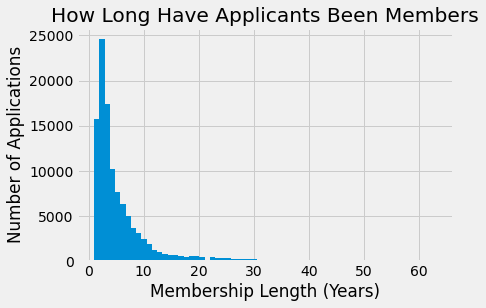

In [204]:
df_clean['Membership Length (Years)'].plot.hist(bins=65)
plt.title('How Long Have Applicants Been Members')
plt.xlabel('Membership Length (Years)')
plt.ylabel('Number of Applications')
plt.show()

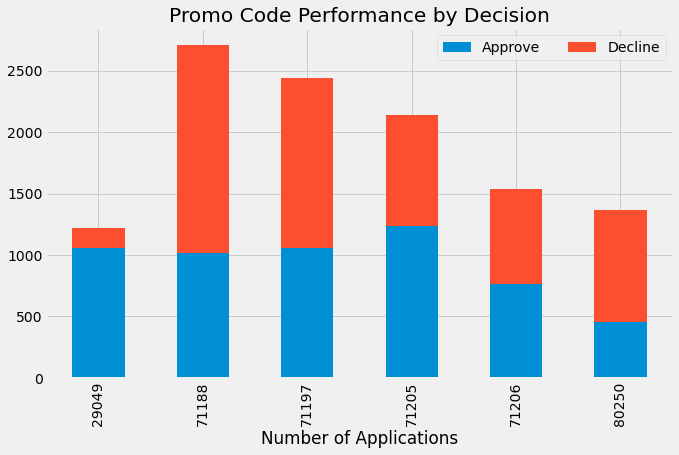

In [256]:
# Select top 6 promo codes
top_promos = df_clean[df_clean['Promo Code'] != 0].groupby('Promo Code').size().reset_index(name='Number of Applications').nlargest(6, 'Number of Applications')
promo_codes = top_promos['Promo Code'].tolist()

# Filter data for top 6 promo codes
df_top_promos = df_clean[df_clean['Promo Code'].isin(promo_codes)]

# Group data by Promo Code and Decision and count the number of applications
promo_decisions = df_top_promos.groupby(['Promo Code', 'Decision']).size().unstack().fillna(0)

# Create stacked horizontal bar chart
ax = promo_decisions.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Promo Code Performance by Decision')
ax.set_xlabel('Number of Applications')
ax.legend(loc='best', ncol=2)


<AxesSubplot:title={'center':'Top 6 Promo Code'}, xlabel='Promo Code', ylabel='Number of Applications'>

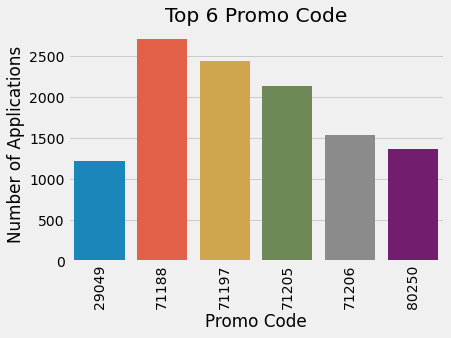

In [202]:
promo_counts = df_onlypromo.groupby("Promo Code").count().reset_index()[["Promo Code", "App Number"]]
promo_counts["Promo Code"] = promo_counts["Promo Code"].astype(int)
promo_counts = promo_counts.rename(columns={"App Number": "Number of Applications"})

ax = sns.barplot(data=promo_counts, x="Promo Code", y="Number of Applications")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Top 6 Promo Code")
sns.barplot(data=promo_counts, x="Promo Code", y="Number of Applications")

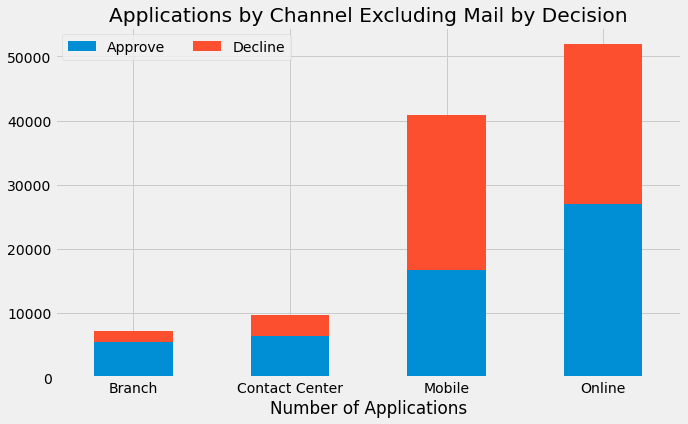

In [273]:
# Filter data for non-mail applications
df_nonmail = df_clean[df_clean['Channel'] != 'Mail']

# Group data by Channel and Decision and count the number of applications
channel_decisions = df_nonmail.groupby(['Channel', 'Decision']).size().unstack().fillna(0)

# Create stacked horizontal bar chart
ax = channel_decisions.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_title('Applications by Channel Excluding Mail by Decision')
ax.set_xlabel('Number of Applications')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel('Number of Applications')
ax.legend(loc='best', ncol=2)
plt.show()


In [221]:
df_firstdecade = df_firstdecade.drop(['App Number'], axis=1)

In [93]:
summarize_dataframe(df_firstdecade)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Direct Deposit,object,0,2,96349.0,2,No,49858,,,,,,,
Application Year,int64,0,2,96349.0,,,,2021.557318,0.496706,2021.0,2021.0,2022.0,2022.0,2022.0
Membership Length (Years),int64,0,10,96349.0,,,,3.656187,2.389964,1.0,2.0,3.0,5.0,10.0
Decision,object,0,2,96349.0,2,Decline,48417,,,,,,,
Product,object,0,6,96349.0,6,cashRewards,34684,,,,,,,
Network,object,0,3,96349.0,3,VISA,73327,,,,,,,
Channel,object,0,5,96349.0,5,Online,45473,,,,,,,
Promo Code,int64,0,27,96349.0,,,,7508.317585,21557.271564,0.0,0.0,0.0,0.0,99966.0


In [94]:
df_onlypromo['Promo Code'].value_counts().head(6)

71188    2711
71197    2437
71205    2135
71206    1533
80250    1368
29049    1221
Name: Promo Code, dtype: int64

### Split and Encode

In [274]:
for column in df_onlypromo.columns:
    if df_onlypromo[column].dtype == object:
        df_onlypromo[column] = LabelEncoder().fit_transform(df_onlypromo[column])

In [275]:
trainData, testData = train_test_split(df_onlypromo, test_size=.20, random_state=1)

In [276]:
trainLabels = LabelEncoder().fit_transform(trainData.Decision)
testLabels = LabelEncoder().fit_transform(testData.Decision)

In [277]:
trainData = trainData.drop(columns = 'Decision')
testData = testData.drop(columns = 'Decision')

### Data Augmentations

In [108]:
from feature_engine.outliers import Winsorizer

out = Winsorizer(tail = "both")

cap_trainData, cap_testData = out.fit_transform(trainData), out.transform(testData)

In [157]:
from feature_engine.creation import MathFeatures

mf = MathFeatures(variables = ['Channel', 'Membership Length (Years)'], 
                  func = "max")

mf_trainData, mf_testData = mf.fit_transform(cap_trainData), mf.fit_transform(cap_testData)

In [158]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(random_state=1, k_neighbors = 5, sampling_strategy = "not majority")
strainData, strainLabels = oversample.fit_resample(mf_trainData, trainLabels)

In [159]:
strainLabels.mean()

0.5

### Modeling

#### XGBoost

In [160]:
test_xgb1 = XGBClassifier(random_state=1)
test_xgb1.fit(strainData, strainLabels)
predictedProbabilities = test_xgb1.predict_proba(mf_testData)
predictedLabels = test_xgb1.predict(mf_testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 65.71
PrecisionNegative: 70.10
PrecisionPositive: 62.94
RecallNegative: 54.43
RecallPositive: 76.92
AUC Score: 71.98



In [ ]:
plot_conf_mat(test_xgb1, # The classifier object
              mf_testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [278]:
# Original
test_xgb = XGBClassifier(random_state=1)
test_xgb.fit(trainData, trainLabels)
predictedProbabilities = test_xgb.predict_proba(testData)
predictedLabels = test_xgb.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 62.21
PrecisionNegative: 65.76
PrecisionPositive: 60.14
RecallNegative: 49.07
RecallPositive: 75.04
AUC Score: 67.03



C:\Users\cantr\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


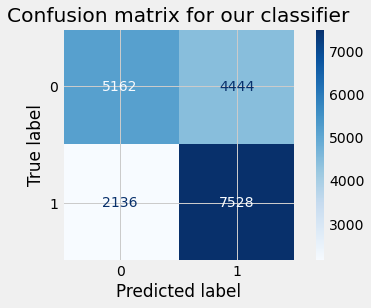

In [105]:
plot_conf_mat(test_xgb, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [ ]:
positiveProbabilities = predictedProbabilities[:,1]
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

#### Hyperopt

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

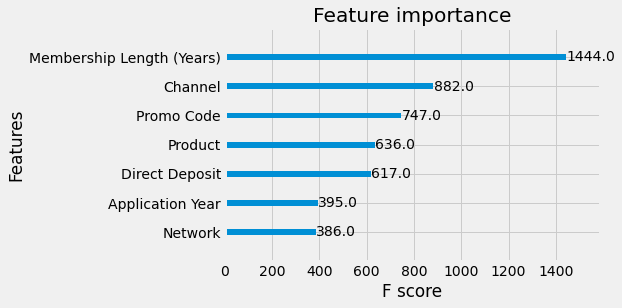

In [227]:
plot_importance(test_xgb)

In [161]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 200, 20),
        'eta': hp.uniform ('eta', 0.1,0.9),
        'seed': 0,
        'random_state': 1
    }

from sklearn.metrics import roc_auc_score

def objective(space):
    clf=XGBClassifier(
        random_state = space['random_state'],
        eta = space['eta'],
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
#         gamma = space['gamma'],
#         reg_alpha = int(space['reg_alpha']),
#         min_child_weight=int(space['min_child_weight']),
#         colsample_bytree=int(space['colsample_bytree'])
    )
    
    evaluation = [( mf_trainData, trainLabels), ( mf_testData, testLabels)]
    
    clf.fit(mf_trainData, trainLabels,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(mf_testData)
    accuracy = roc_auc_score(testLabels, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [162]:
%%capture

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 300,
                        trials = trials)

In [163]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'eta': 0.5599352485569663, 'max_depth': 6.0, 'n_estimators': 120.0, 'reg_alpha': 116.0}


In [186]:
best_hyperparams = {'max_depth': 6, 'reg_alpha': 116.0, 
                    'n_estimators': 120, 'eta': 0.5599352485569663}

best_xgb = XGBClassifier(**best_hyperparams, random_state=1)
best_xgb.fit(mf_trainData, trainLabels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.5599352485569663,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=120, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [187]:
predictedProbabilities = best_xgb.predict_proba(mf_testData)
predictedLabels = best_xgb.predict(mf_testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 65.82
PrecisionNegative: 71.99
PrecisionPositive: 62.40
RecallNegative: 51.45
RecallPositive: 80.10
AUC Score: 71.97



In [ ]:
summarize_dataframe(df_clean)

#### RandomForest Grid Search

In [ ]:
%%time
%%capture --no-display

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=1)
param_grid = {'max_depth': [10, 12, 14],  
              'n_estimators': [100,150], 
              'max_features' : [7],
              'random_state' : [6]}

scorer = make_scorer(recall_score, pos_label=1) # We are optimizing based on recall of 'yes' class (original pos_label=1)

search = GridSearchCV(rf, param_grid, scoring = scorer, cv=5
                     , verbose=3)
grid = search.fit(trainData, trainLabels)

In [ ]:
# Predict on test data
predictions = grid.best_estimator_.predict(testData) # This will give binary labels e.g 0/1
predictionProbabilities = grid.best_estimator_.predict_proba(testData) # This will give prediction probabilities for both labels e.g [0.3, 0.7] meaning 0.3 probability for 'no' and 0.7 for 'yes'.

# Calculate metrics on test set and display them
calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

In [ ]:
#Generate confusion matrices for the different models' training fit
#non-weighted model
confusionMatrix = None
confusionMatrix = confusion_matrix(testLabels, predictions)

## confusion matrix
plt.rcParams['figure.figsize'] = [5, 5] ## plot size
displayConfusionMatrix(confusionMatrix)
plt.title("Model", fontsize=PLOT_FONT_SIZE)
plt.show()

#### SVM Search

In [ ]:
%%time

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

sv = make_pipeline(StandardScaler(), 
                   svm.SVC(gamma='auto', probability = True))

sv.fit(trainData, trainLabels)

In [ ]:
# Predict on test data
predictions = sv.predict(testData) # This will give binary labels e.g 0/1
predictionProbabilities = sv.predict_proba(testData) # This will give prediction probabilities for both labels e.g [0.3, 0.7] meaning 0.3 probability for 'no' and 0.7 for 'yes'.

# Calculate metrics on test set and display them
calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)


In [ ]:
#Generate confusion matrices for the different models' training fit
#non-weighted model
confusionMatrix = None
confusionMatrix = confusion_matrix(testLabels, predictions)

## confusion matrix
plt.rcParams['figure.figsize'] = [5, 5] ## plot size
displayConfusionMatrix(confusionMatrix)
plt.title("Model", fontsize=PLOT_FONT_SIZE)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

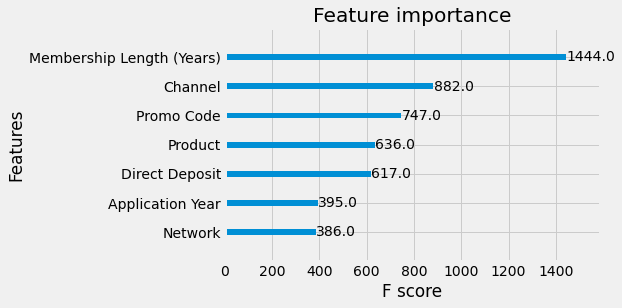

In [106]:
# plot feature importance
plot_importance(test_xgb, importance_type = "weight",  max_num_features=15)